<a href="https://colab.research.google.com/github/hamidb201214-svg/Lectures/blob/main/IMPACT_Unsloth_VLM_Tutorial_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# IMPACT (AI4Patents) + Unsloth — Fine-tune a Vision-Language Model on Design Patent Figures

**The Primary Goal:** *The primary goal of this code is to teach a Vision-Language Model (VLM) how to behave like a patent analyst. By fine-tuning on the IMPACT dataset, the model learns the specific "language of patents"—moving away from generic image descriptions (e.g., "a drawing of a shoe") toward technical, concrete visual descriptions (e.g., "A side view of a footwear design featuring a textured midsole and ornamental stitching on the heel") that are required for design patent documentation.*

**To run this, press `Runtime` → `Run all` on a free Tesla T4 Google Colab instance.**

This teaching notebook shows:
1. **Data prep** with `AI4Patents/IMPACT` (sample-first, full dataset optional)
2. **Finetuning** a Vision-Language Model (VLM) with **Unsloth + LoRA**
3. **Inference** before/after training
4. **Quick evaluation**
5. **Saving & reloading** LoRA adapters (and optional merged weights)

> Dataset: IMPACT (Integrated Multimodal Patent Analysis and CreaTion Dataset) — design patent figures + captions (USPTO, 2007–2022).  
> License: **CC BY-SA 4.0** (dataset). Respect the license when sharing derivatives.


## 0) Setup (GPU)  
In Colab: `Runtime` → `Change runtime type` → **GPU** (Tesla T4 is enough for this demo).

In [1]:
%%capture
import os, re

# Unsloth's Colab-friendly install pattern (keeps installs reasonably fast on free T4)
if "COLAB_" not in "".join(os.environ.keys()):
    !pip -q install unsloth
else:
    import torch
    v = re.match(r'[\d]{1,}\.[\d]{1,}', str(torch.__version__)).group(0)
    xformers = 'xformers==' + {'2.10':'0.0.34','2.9':'0.0.33.post1','2.8':'0.0.32.post2'}.get(v, "0.0.34")
    !pip -q install sentencepiece protobuf "datasets==4.3.0" "huggingface_hub>=0.34.0" hf_transfer
    !pip -q install --no-deps unsloth_zoo bitsandbytes accelerate {xformers} peft trl triton unsloth

# Pin known-good versions (adjust if you already have newer working installs)
!pip -q install "transformers==4.56.2"
!pip -q install --no-deps "trl==0.22.2"

print("✅ Installed! Restart runtime if Colab asks.")


## 1) Load a VLM (Qwen2-VL 2B) + add LoRA adapters

We use a 4-bit quantized VLM so it fits comfortably on a free T4.  
Then we add **LoRA adapters** so we train only a small fraction of parameters.

In [2]:
from unsloth import FastVisionModel
import torch

MODEL_NAME = "unsloth/Qwen2-VL-2B-Instruct-bnb-4bit"

model, tokenizer = FastVisionModel.from_pretrained(
    MODEL_NAME,
    load_in_4bit = True,                  # 4bit = lower VRAM
    use_gradient_checkpointing = "unsloth" # helps with longer context
)

# Add LoRA adapters (parameter-efficient finetuning)
model = FastVisionModel.get_peft_model(
    model,
    finetune_vision_layers     = True,
    finetune_language_layers   = True,
    finetune_attention_modules = True,
    finetune_mlp_modules       = True,

    r = 16,
    lora_alpha = 16,
    lora_dropout = 0,
    bias = "none",
    random_state = 3407,
    use_rslora = False,
    loftq_config = None,
)

print("✅ Model + LoRA ready.")


🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2026.2.1: Fast Qwen2_Vl patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.563 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/1.54G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/238 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/572 [00:00<?, ?B/s]

The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.


tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/11.4M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/392 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/614 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

Unsloth: Making `model.base_model.model.model.visual` require gradients
✅ Model + LoRA ready.


## 2) Get IMPACT data (sample-first)

**Why sample-first?** The full IMPACT dataset is very large (yearly ZIPs are multiple GB).  
For teaching and quick iteration, we start with the repo’s **Sample data** (small), then show an **optional** section for pulling a small subset from Hugging Face.

If the repo layout changes, this notebook tries to discover files automatically.

In [3]:
from pathlib import Path

REPO_URL = "https://github.com/AI4Patents/IMPACT.git"
repo = Path("IMPACT")
sample_dir = repo / "Sample data"

# Clone once (if needed)
if not repo.exists():
    !git clone -q {REPO_URL}

print("Repo exists:", repo.exists())
print("Sample dir:", sample_dir, "exists:", sample_dir.exists())

# Quick tree (first ~200 paths)
if sample_dir.exists():
    for p in list(sample_dir.rglob("*"))[:200]:
        print(p)
else:
    print("Sample data folder not found. Use the Hugging Face download option later.")


Repo exists: True
Sample dir: IMPACT/Sample data exists: True
IMPACT/Sample data/USD0938702-20211221
IMPACT/Sample data/USD0934827-20211102
IMPACT/Sample data/USD0933282-20211012
IMPACT/Sample data/USD0925765-20210720
IMPACT/Sample data/USD0938703-20211221
IMPACT/Sample data/USD0908314-20210126
IMPACT/Sample data/USD0927435-20210810
IMPACT/Sample data/USD0917867-20210504
IMPACT/Sample data/sample_data.csv
IMPACT/Sample data/USD0909824-20210209
IMPACT/Sample data/USD0915080-20210406
IMPACT/Sample data/USD0910058-20210209
IMPACT/Sample data/USD0919622-20210518
IMPACT/Sample data/.DS_Store
IMPACT/Sample data/USD0913175-20210316
IMPACT/Sample data/USD0925503-20210720
IMPACT/Sample data/USD0929296-20210831
IMPACT/Sample data/USD0907292-20210105
IMPACT/Sample data/USD0927652-20210810
IMPACT/Sample data/USD0928145-20210817
IMPACT/Sample data/USD0921835-20210608
IMPACT/Sample data/USD0907293-20210105
IMPACT/Sample data/USD0937859-20211207
IMPACT/Sample data/USD0937858-20211207
IMPACT/Sample da

### 2.1 Load sample CSV + set the dataset schema

We’ll:
- Find a CSV inside `IMPACT/Sample data/`
- Read it with pandas
- **Set the key column names once** (image filenames + captions)

> The IMPACT sample CSV stores **lists** of figure filenames and captions per patent.
  To keep this notebook easy to follow, we *don’t* do any heuristic column guessing.
  Instead, we print `df.columns` and you edit the `COL_*` variables in the next cell.


In [4]:
import pandas as pd
from pathlib import Path

sample_dir = Path("IMPACT") / "Sample data"
csvs = sorted(sample_dir.rglob("*.csv")) if sample_dir.exists() else []
if not csvs:
    raise FileNotFoundError(
        "No sample CSV found. If the repo layout changed, skip to the HF download section below."
    )

csv_path = csvs[0]
print("Using CSV:", csv_path)

df = pd.read_csv(csv_path)
print("Rows:", len(df))
print("Columns:", df.columns.tolist())

# =====================
# IMPORTANT: EDIT THESE
# =====================
# Column with a *list* (or list-like string) of figure filenames / relative paths.
COL_FILE_NAMES = "file_names"

# Column with a *list* (or list-like string) of captions aligned with COL_FILE_NAMES.
COL_CAPTIONS   = "caption"

# Optional: extra per-figure descriptions aligned with COL_FILE_NAMES (set to None if not present).
COL_FIG_DESC   = "fig_desc"

# Root folder where images live for the sample data.
IMAGE_ROOT = sample_dir

# Validate required columns
missing = [c for c in [COL_FILE_NAMES, COL_CAPTIONS] if c not in df.columns]
if missing:
    raise KeyError(
        f"Missing columns: {missing}. Update COL_FILE_NAMES / COL_CAPTIONS above based on df.columns."
    )

if COL_FIG_DESC is not None and COL_FIG_DESC not in df.columns:
    print(f"Note: {COL_FIG_DESC!r} not found; continuing without fig_desc.")
    COL_FIG_DESC = None


Using CSV: IMPACT/Sample data/sample_data.csv
Rows: 50
Columns: ['title', 'id', 'claim', 'date', 'class', 'class_search', 'inv_country', 'no_figs', 'sheets', 'file_names', 'fig_desc', 'caption']


### 2.2 Preview a few examples

In [5]:
import ast, re
import pandas as pd

def parse_maybe_list(x):
    """Turn list-like strings into Python lists.

    The IMPACT CSV often stores lists as strings like "['a','b']".
    """
    if isinstance(x, list):
        return x
    if not isinstance(x, str):
        return []
    s = x.strip()
    # Looks like "['a', 'b', ...]" → parse safely
    if s.startswith("[") and s.endswith("]"):
        try:
            v = ast.literal_eval(s)
            if isinstance(v, list):
                return [str(i).strip() for i in v]
        except Exception:
            pass
    # Fallback: split on commas/semicolons
    parts = [p.strip().strip("'\"") for p in re.split(r"[;,]\s*", s) if p.strip()]
    return parts if parts else [s.strip("'\"")]

# Explode patents → figures (one row per image)
rows = []
for _, r in df.iterrows():
    files = parse_maybe_list(r.get(COL_FILE_NAMES))
    caps  = parse_maybe_list(r.get(COL_CAPTIONS))
    descs = parse_maybe_list(r.get(COL_FIG_DESC)) if COL_FIG_DESC else []

    for i, f in enumerate(files):
        cap  = caps[i]  if i < len(caps)  else (caps[0]  if caps  else "")
        desc = descs[i] if i < len(descs) else (descs[0] if descs else "")
        rows.append({
            "title": r.get("title", ""),
            "id": r.get("id", ""),
            "date": r.get("date", ""),
            "class": r.get("class", ""),
            "file_name": str(f).strip(),
            "caption_i": str(cap).strip(),
            "fig_desc_i": str(desc).strip(),
        })

df_fig = pd.DataFrame(rows)
print("Exploded rows (figures):", len(df_fig))
print(df_fig[["file_name","caption_i"]].head(3))


Exploded rows (figures): 438
                        file_name  \
0  USD0937859-20211207-D00000.TIF   
1  USD0937859-20211207-D00001.TIF   
2  USD0908314-20210126-D00000.TIF   

                                           caption_i  
0                              The image is a square  
1  and it displays a graphical user interface wit...  
2  The image is a square-shaped illustration of a...  


In [6]:
from pathlib import Path

def resolve_image_path_from_filename(filename, root=IMAGE_ROOT):
    if not isinstance(filename, str) or not filename.strip():
        return None

    name = filename.strip().strip("'\"")
    p = Path(name)

    # If it already includes a subpath, try that relative to root
    p2 = root / p
    if p2.is_file():
        return p2

    # Try just the basename
    p3 = root / p.name
    if p3.is_file():
        return p3

    # Last resort (small sample ok): search recursively by basename
    hits = list(root.rglob(p.name))
    return hits[0] if hits else None


In [7]:
for i in range(5):
    fn = df_fig.iloc[i]["file_name"]
    path = resolve_image_path_from_filename(fn)
    print(fn, "->", path)


USD0937859-20211207-D00000.TIF -> IMPACT/Sample data/USD0937859-20211207/USD0937859-20211207-D00000.TIF
USD0937859-20211207-D00001.TIF -> IMPACT/Sample data/USD0937859-20211207/USD0937859-20211207-D00001.TIF
USD0908314-20210126-D00000.TIF -> IMPACT/Sample data/USD0908314-20210126/USD0908314-20210126-D00000.TIF
USD0908314-20210126-D00001.TIF -> IMPACT/Sample data/USD0908314-20210126/USD0908314-20210126-D00001.TIF
USD0908314-20210126-D00002.TIF -> IMPACT/Sample data/USD0908314-20210126/USD0908314-20210126-D00002.TIF


## 3) Convert to Unsloth VLM chat format

Vision finetuning expects each example as:

```python
[
  {"role":"user","content":[{"type":"text","text":...}, {"type":"image","image":...}]},
  {"role":"assistant","content":[{"type":"text","text":...}]},
]
```

We’ll build an instruction that teaches the model to describe **design patent figures**.

In [8]:
from PIL import Image

CAPTION_COL = "caption_i"
IMAGE_COL   = "file_name"

INSTRUCTION = (
    "You are a design patent analyst. "
    "Describe the product and key visual features shown in this patent figure. "
    "Be concrete (shape, parts, proportions) in 1–3 sentences."
)

def row_to_example(row):
    img_path = resolve_image_path_from_filename(row[IMAGE_COL])
    if img_path is None:
        return None
    caption = str(row.get(CAPTION_COL, "")).strip()
    if not caption:
        return None

    im = Image.open(img_path)
    # TIFFs can be multi-frame; use first frame
    try:
        im.seek(0)
    except Exception:
        pass
    im = im.convert("RGB")

    return {
        "messages": [
            {"role": "user", "content": [
                {"type": "text", "text": INSTRUCTION},
                {"type": "image", "image": im},
            ]},
            {"role": "assistant", "content": [
                {"type": "text", "text": caption},
            ]},
        ]
    }

examples = []
for _, row in df_fig.iloc[:50, :].iterrows():
    ex = row_to_example(row)
    if ex is not None:
        examples.append(ex)

print("Prepared examples:", len(examples))

Prepared examples: 50


## 4) Baseline inference (before training)

Let’s see what the base VLM says about one figure.

In [9]:
from transformers import TextStreamer
from unsloth import FastVisionModel

FastVisionModel.for_inference(model)

# pick an example
sample = examples[0]["messages"][0]["content"][1]["image"]  # the PIL image
messages = [{"role":"user","content":[{"type":"image"}, {"type":"text","text":INSTRUCTION}]}]

input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
inputs = tokenizer(sample, input_text, add_special_tokens=False, return_tensors="pt").to("cuda")

streamer = TextStreamer(tokenizer, skip_prompt=True)
_ = model.generate(
    **inputs,
    streamer=streamer,
    max_new_tokens=128,
    use_cache=True,
    temperature=1.2,
    min_p=0.1,
)


The patent figure shows a circular object with a central hole, surrounded by concentric circles that appear to be radiating outwards. The object is centrally located and appears to be a part of a larger design or structure.<|im_end|>


## 5) Train (SFT)

We’ll do a short run (**~30–80 steps**) so it finishes quickly on a free T4.  
For better results, increase `max_steps` or use `num_train_epochs=1`.

In [10]:
from unsloth.trainer import UnslothVisionDataCollator
from trl import SFTTrainer, SFTConfig
from unsloth import FastVisionModel

FastVisionModel.for_training(model)

# quick train/val split
from datasets import Dataset
ds = Dataset.from_list(examples).train_test_split(test_size=0.1, seed=3407)
train_ds, eval_ds = ds["train"], ds["test"]

trainer = SFTTrainer(
    model=model,
    tokenizer=tokenizer,
    data_collator=UnslothVisionDataCollator(model, tokenizer),
    train_dataset=train_ds,
    eval_dataset=eval_ds.select(range(min(30, len(eval_ds)))),  # small eval on T4
    args=SFTConfig(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        warmup_steps=5,
        max_steps=50,                 # 👈 change to 200+ for better results
        learning_rate=2e-4,
        logging_steps=1,
        optim="adamw_8bit",
        weight_decay=0.001,
        lr_scheduler_type="linear",
        seed=3407,
        output_dir="outputs",
        report_to="none",

        # required for vision finetuning
        remove_unused_columns=False,
        dataset_text_field="",
        dataset_kwargs={"skip_prepare_dataset": True},
        max_length=2048,
    ),
)

trainer_stats = trainer.train()
trainer_stats


Unsloth: Model does not have a default image size - using 512


==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 45 | Num Epochs = 9 | Total steps = 50
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 28,950,528 of 2,237,936,128 (1.29% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss
1,4.016300
2,3.683200
3,3.931600
4,4.132200
5,4.121300
6,3.749900
7,3.672600
8,3.280800
9,2.760500
10,2.463300


TrainOutput(global_step=50, training_loss=1.1759932446479797, metrics={'train_runtime': 652.2216, 'train_samples_per_second': 0.613, 'train_steps_per_second': 0.077, 'total_flos': 2528214276111360.0, 'train_loss': 1.1759932446479797, 'epoch': 8.347826086956522})

## 6) Inference (after training)

Same prompt, same image — now with LoRA adapters active.

Sample image size: (953, 1657)


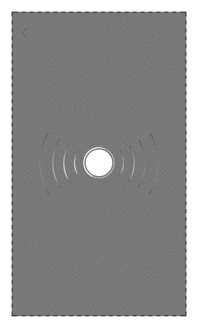

The image is a square-shaped illustration of a circular object


In [11]:
from transformers import TextStreamer
from unsloth import FastVisionModel
from PIL import Image
from io import BytesIO
import torch
import matplotlib.pyplot as plt

# --- Robust image handling (PIL / dict / path) ---
def ensure_pil(x):
    if isinstance(x, Image.Image):
        return x.convert("RGB")
    if isinstance(x, str):
        return Image.open(x).convert("RGB")
    if isinstance(x, dict):
        if x.get("bytes", None) is not None:
            return Image.open(BytesIO(x["bytes"])).convert("RGB")
        if x.get("path", None):
            return Image.open(x["path"]).convert("RGB")
        for k in ("image", "data"):
            if k in x:
                return ensure_pil(x[k])
    raise TypeError(f"Unsupported image type: {type(x)}")

# Ensure inference mode (and adapters are ON)
FastVisionModel.for_inference(model)
model.eval()

# Pull a sample image from our prepared examples
sample_img = ensure_pil(examples[0]["messages"][0]["content"][1]["image"])
print("Sample image size:", sample_img.size)

# (Optional) visualize the image
plt.figure(figsize=(4,4))
plt.imshow(sample_img)
plt.axis("off")
plt.show()

# Qwen2-VL expects an image placeholder in the chat template,
# and you pass the actual PIL image to the tokenizer separately.
messages = [{"role":"user","content":[{"type":"image"}, {"type":"text","text":INSTRUCTION}]}]

input_text = tokenizer.apply_chat_template(messages, add_generation_prompt=True)
inputs = tokenizer(
    sample_img,
    input_text,
    add_special_tokens=False,
    return_tensors="pt",
).to("cuda")

# Stream output nicely (no prompt, no special tokens)
streamer = TextStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

with torch.inference_mode():
    _ = model.generate(
        **inputs,
        streamer=streamer,
        max_new_tokens=160,
        use_cache=True,
        do_sample=True,
        temperature=1.5,
        min_p=0.1,
        repetition_penalty=1.05,
    )


## 7) Quick evaluation (ROUGE on a tiny eval subset)

This is *not* a perfect metric for captions, but it’s a quick sanity check.
We compare:
- **Base model** (freshly loaded, no LoRA)
- **Finetuned model** (LoRA adapters)

We keep evaluation small to stay fast on a free T4.

In [ ]:
import evaluate
import torch
from tqdm.auto import tqdm
from unsloth import FastVisionModel

rouge = evaluate.load("rouge")

def generate_caption(vlm, tok, image, instruction, max_new_tokens=96):
    # `ensure_pil` was defined in the inference cell above.
    image = ensure_pil(image)
    msgs = [{"role":"user","content":[{"type":"image"}, {"type":"text","text":instruction}]}]
    input_text = tok.apply_chat_template(msgs, add_generation_prompt=True)
    inputs = tok(image, input_text, add_special_tokens=False, return_tensors="pt").to("cuda")
    with torch.no_grad():
        out = vlm.generate(**inputs, max_new_tokens=max_new_tokens, do_sample=False, use_cache=True)
    gen_ids = out[0][inputs["input_ids"].shape[1]:]
    return tok.decode(gen_ids, skip_special_tokens=True).strip()

# Reload the base model for a fair comparison (no LoRA)
base_model, base_tok = FastVisionModel.from_pretrained(
    MODEL_NAME,
    load_in_4bit=True,
    use_gradient_checkpointing="unsloth",
)
FastVisionModel.for_inference(base_model)
FastVisionModel.for_inference(model)

eval_small = eval_ds.select(range(min(25, len(eval_ds))))

refs, base_preds, ft_preds = [], [], []
for ex in tqdm(eval_small, desc="Evaluating"):
    img = ex["messages"][0]["content"][1]["image"]
    ref = ex["messages"][1]["content"][0]["text"]
    refs.append(ref)

    base_preds.append(generate_caption(base_model, base_tok, img, INSTRUCTION))
    ft_preds.append(generate_caption(model, tokenizer, img, INSTRUCTION))

base_scores = rouge.compute(predictions=base_preds, references=refs)
ft_scores   = rouge.compute(predictions=ft_preds,   references=refs)

print("Base ROUGE:", base_scores)
print("FT   ROUGE:", ft_scores)

# Show a few qualitative examples
for i in range(min(3, len(refs))):
    print("="*100)
    print("REF :", refs[i][:300])
    print("BASE:", base_preds[i][:300])
    print("FT  :", ft_preds[i][:300])


==((====))==  Unsloth 2026.2.1: Fast Qwen2_Vl patching. Transformers: 4.56.2.
   \\   /|    Tesla T4. Num GPUs = 1. Max memory: 14.563 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.9.0+cu128. CUDA: 7.5. CUDA Toolkit: 12.8. Triton: 3.5.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.33.post1. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]

Base ROUGE: {'rouge1': np.float64(0.08329435636485974), 'rouge2': np.float64(0.0064516129032258064), 'rougeL': np.float64(0.08421213045123847), 'rougeLsum': np.float64(0.08421213045123849)}
FT   ROUGE: {'rouge1': np.float64(0.44096736596736597), 'rouge2': np.float64(0.3486291486291487), 'rougeL': np.float64(0.44475524475524464), 'rougeLsum': np.float64(0.44096736596736597)}
REF : The image is a cylindrical shape
BASE: The patent figure shows a vertical device with multiple vertical rods or bars. The rods are evenly spaced and aligned vertically. The device appears to be a type of vertical support or rack, possibly used for holding or organizing items. The figure includes a label "FIG. 5" indicating it is a fifth 
FT  : which is a type of
REF : which can be useful for potential customers or designers to visualize the product and its details.
BASE: The patent figure shows two different designs of a long-sleeved, hooded jacket. The jacket in Figure 2 has a front pocket and a zipper on the

## 8) Save / load LoRA adapters

This saves only the LoRA adapters (small), not the full base model weights.

In [ ]:
SAVE_DIR = "impact_qwen2vl_lora"

model.save_pretrained(SAVE_DIR)
tokenizer.save_pretrained(SAVE_DIR)

print("✅ Saved LoRA + tokenizer to:", SAVE_DIR)

# --- Optional: reload later for inference ---
if False:
    from unsloth import FastVisionModel
    reloaded, reloaded_tok = FastVisionModel.from_pretrained(
        model_name=SAVE_DIR,
        load_in_4bit=True,
    )
    FastVisionModel.for_inference(reloaded)
    print("Reloaded!")


✅ Saved LoRA + tokenizer to: impact_qwen2vl_lora


## 9) (Optional) Use the full Hugging Face dataset (advanced)

The HF repo stores **yearly CSVs** and **yearly ZIPs**. ZIPs are multiple GB.  
This section shows how to:
- download a year CSV
- optionally open the year ZIP and extract **only a handful** of images for a tiny experiment

⚠️ This is optional and may still be slow depending on bandwidth.

In [ ]:
# --- OPTIONAL ---
# Download one year CSV from Hugging Face (about ~35–60MB)
from huggingface_hub import hf_hub_download, hf_hub_url
import pandas as pd

YEAR = "2012"  # pick 2007..2022
csv_file = f"{YEAR}.csv"

csv_path = hf_hub_download(repo_id="AI4Patents/IMPACT", filename=csv_file, repo_type="dataset")
print("Downloaded:", csv_path)

full_df = pd.read_csv(csv_path)
print("Rows:", len(full_df))
print("Columns:", list(full_df.columns)[:30])

# If you want images too, you can download the corresponding ZIP (multi-GB) OR try the "remote zip" trick.


2012.csv:   0%|          | 0.00/36.6M [00:00<?, ?B/s]

Downloaded: /root/.cache/huggingface/hub/datasets--AI4Patents--IMPACT/snapshots/226d8a17ab6cc03637ca4d5a82b39ec99d61f14b/2012.csv
Rows: 21959
Columns: ['title', 'id', 'claim', 'date', 'class', 'class_search', 'inv_country', 'no_figs', 'sheets', 'file_names', 'fig_desc', 'caption']


In [ ]:
# --- OPTIONAL (advanced): read a few images from the remote ZIP without downloading the whole file ---
# This uses HTTP range requests + zipfile central directory reading.
# Works only if the server supports range requests for the resolved ZIP URL.

import zipfile, fsspec, io
from huggingface_hub import hf_hub_url

YEAR = "2012"
zip_name = f"{YEAR}.zip"
zip_url = hf_hub_url(repo_id="AI4Patents/IMPACT", filename=zip_name, repo_type="dataset")
print("ZIP URL:", zip_url)

# open remote ZIP as a file-like object
http_fs = fsspec.filesystem("https")
f = http_fs.open(zip_url, "rb")

zf = zipfile.ZipFile(f)
all_names = zf.namelist()
print("Files inside zip:", len(all_names))
print("First 10 names:", all_names[:10])

# You now need to map rows in the CSV to filenames inside the ZIP.
# A common pattern is that the CSV has a column containing the figure filename/path.
# Inspect full_df columns to find it, then use zf.read(filename) to get bytes.

# Example (pseudo):
# img_bytes = zf.read(filename_from_csv)
# image = Image.open(io.BytesIO(img_bytes)).convert("RGB")


ZIP URL: https://huggingface.co/datasets/AI4Patents/IMPACT/resolve/main/2012.zip
Files inside zip: 365634
First 10 names: ['2012/', '2012/USD0671441-20121127/', '__MACOSX/2012/._USD0671441-20121127', '2012/USD0654712-20120228/', '__MACOSX/2012/._USD0654712-20120228', '2012/USD0670255-20121106/', '__MACOSX/2012/._USD0670255-20121106', '2012/USD0658794-20120501/', '__MACOSX/2012/._USD0658794-20120501', '2012/USD0672266-20121211/']


## Done 🎉

Ideas for exercises:
- Change the instruction to generate **product category labels**
- Train a **retrieval model** (e.g., CLIP / PatentCLIP) using captions vs titles
- Add **multi-turn conversations** (ask about viewpoint, materials, novelty)

If you want, tell me what columns your CSV has (screenshot or paste `df.columns`) and I can tailor the notebook to your exact schema.